In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *
import time
#mean squared error: 0.00302
#params=np.array([\
# 1.00019169, 1.00485457, 0.98089897,\
# 0.00173489, 0.03556878, 0.19213672,\
# 0.99867178, 0.00847006, 0.02213006, 0.12979466]

#msqerr: 0.0029
#[ 1.0003588   1.00501068  0.98071385  0.00298074  0.0019567   0.20618256
#  1.03816403 -0.02316948 -0.01194352  0.12074971]

#msqerr: 0.0016
#[ 1.00019457  1.00488652  0.98081785  0.00157861  0.03279509  0.19761574
#  0.99666972  0.00134338  0.0370082  -0.02798724]

In [168]:
#Read in the raw data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the magnetometer data in numpy form
dfMag=raw_dat['mag']
mag=dfMag.to_numpy()
# Get the magnetometer time series in seconds
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]

# Synch the gyro to the magnetometer, convert to radians/s
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()

#Sync the accelerometer to the gyro
#the 8g accelerometer is by far the best.
acc=   synchronize_series(raw_dat['accIMU'],ref=dfMag).to_numpy()


Successfully loaded  Ch80_8g_DC_Acceleration.csv
Successfully loaded  Ch32_16g_DC_Acceleration.csv
Successfully loaded  Ch43_IMU_Acceleration.csv
Successfully loaded  Ch47_Rotation.csv
Successfully loaded  Ch51_IMU_Magnetic_Field.csv


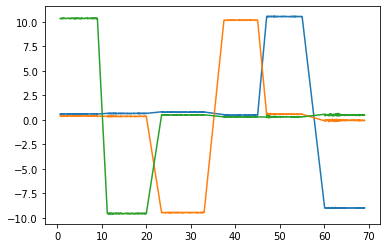

In [169]:
## Find the intervals where the sensor is stationary
intervals=[\
          (0.6,9),\
          (11.2,20),\
          (23.4,33),\
          (37.4,45),\
          (47,55),\
          (60,69),\
          ]       


ts_0,acc_0=idx_filter(ts,acc,intervals)
plt.plot(ts_0,acc_0)

In [155]:
#Variances



9.850842058263225
0.024805092213898185


In [170]:
#params=[scale0,scale1,scale2,bias1,bias2,bias3,qw,qx,qy,qz]

#Initial guess
#params=np.array([\
#    1.0,1.0,1.0,\
#    0.0,0.0,0.0,\
#    1.0,0.0,0.0,0.0 \
#    ])

#ACC 8
#([ 1.00019457,  1.00488652,  0.98081785,  0.00157861,  0.03279509,
#        0.19761574,  0.99666972,  0.00134338,  0.0370082 , -0.02798724])

#ACC16
#([ 0.99947972,  0.9985753 ,  1.0101357 ,  0.163847  ,  0.57478074,
#        0.44491193,  0.99663155,  0.00126076,  0.03802838, -0.02799045])

#ACCIMU

#Use the last best guess
params=[ 1.00019457,  1.00488652,  0.98081785,  \
        0.00157861,  0.03279509,   0.19761574,  \
        0.99666972,  0.00134338,  0.0370082 , -0.02798724]

print(msqError(params,intervals,acc,gyro,mag,ts))

##Allocate arrays once for speedup
#workspace={}
#num_samples=len(ts)
#workspace['acc_scratch']=np.zeros((num_samples,3))
#workspace['Q']=np.tile(np.array([1.0,0.0,0.0,0.0]),(num_samples,1))
#workspace['Q_quat']=np.tile(Quaternion(np.array([1.0,0.0,0.0,0.0])),(num_samples,1))
#workspace['acc_lab']=np.zeros((num_samples,3))
#func = lambda params: msqError(params,intervals,acc,gyro,mag,ts,workspace=workspace)


##Takes 223 seconds to compute with preallocation
## 209 seconds without preallocation
func = lambda params: msqError(params,intervals,acc,gyro,mag,ts)

tic=time.time()
sol=minimize(func,params)
toc=time.time()

print(f"Minimization took {toc-tic:0.1f} seconds")
print(sol)

0.3611178776411957


KeyboardInterrupt: 

(0.9989 +0.0013i +0.0371j -0.0281k)


Text(0, 0.5, 'lab frame acceleration (m/s^2)')

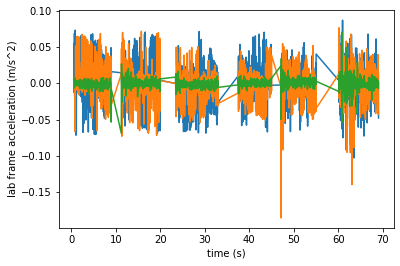

In [157]:

params=sol.x
q=np.array(params[6:])
q/=np.linalg.norm(q)
q0=Quaternion(q)
print(q0)

## Apply scale-bias calibration
acc_calibrated=calibrate(acc,params=params)
acc_1=calibrate(acc,params=params)
# Rotate into lab frame using initial orientation
for i in range(len(acc_calibrated)):
    acc_calibrated[i]=q0.rotate(acc_calibrated[i])

#plt.plot(ts,acc_calibrated)

# Use madgwick filter to estimate orientation, and integrate to find position estimate
ACC_LAB,QIMU,state=apply_ahrs(gyro,acc_calibrated,mag,ts,q0=q,g=[0,0,9.799],position=True)

#Plot the quiet parts of the calibration data
ts_0,ACC_LAB0=idx_filter(ts,ACC_LAB,intervals)
plt.plot(ts_0,ACC_LAB0)
plt.xlabel("time (s)")
plt.ylabel("lab frame acceleration (m/s^2)")

In [167]:
#Variances
Ex=0
for i in range(0,len(acc_0)):
    Ex+=np.sqrt(acc_0[i][0]**2+acc_0[i][1]**2+acc_0[i][2]**2)
Ey=Ex/len(acc_0)
print(Ey)
Vx=0
for i in range(0,len(acc_0)):
    Vx+=(np.sqrt(acc_0[i][0]**2+acc_0[i][1]**2+acc_0[i][2]**2)-E)**2
Vy=Vx/len(acc_0)
print(Vy)
Ea=0
for i in range(0,len(acc_calibrated)):
    Ea+=np.sqrt(acc_calibrated[i][0]**2+acc_calibrated[i][1]**2+acc_calibrated[i][2]**2)
E=Ea/len(acc_calibrated)
print(E)
Va=0
for i in range(0,len(acc_calibrated)):
    Va+=(np.sqrt(acc_calibrated[i][0]**2+acc_calibrated[i][1]**2+acc_calibrated[i][2]**2)-E)**2
V=Va/len(acc_calibrated)
print(V)
#by axis
Eq=0
for i in range(0,300):
    Eq+=acc_1[550+i][0]
Ee=Eq/300
print(Ee)
Vq=0
for i in range(0,300):
    Vq+=(acc_1[550+i][0]-Ee)**2
Ve=Vq/300
print(Ve)

#Variances

#Magnitude (before calibration)
#AccIMU  Mean 9.822206779997371, Variance 0.2971266830753489
#Acc8  Mean Variance 9.850842058263225, Variance 0.024805092213898185
#Acc16  Mean 9.824065307170747 Variance 0.19734356325459834

#8g (calibrated) Mean 0.9810117429733292 Variance 0.29803370137317653

#before calibration
#  X Mean -0.14675217576 Variance 9.176494109298067e-05
#  Y Mean 0.055135798976086954 Variance 0.002027292783749168
#  Z Mean -0.15779439122166672 Variance 0.01207981745842745

#Postcalibration (but not rotated)
#  X Mean -0.11208952767891162 Variance 0.01849867988465188
#  Y Mean 0.0957036145951876 Variance 0.008520532072741331
#  Z Mean -0.02936656007248023 Variance 0.0035967816946242833

#16g (calibrated) Mean 0.80516803501322 Variance 0.27047331923864487

#before calibration 
#  X Mean -0.24493033289166674 Variance 0.00382771648171553
#  Y Mean -0.4649625926043478 Variance 0.009259527566590502
#  Z Mean -0.4802495616083332 Variance 0.01534842517610468

#Postcalibrated (but not rotated)
#  X Mean -0.05190969901152744 Variance 0.04036818459884189
#  Y Mean 0.12150321041342556 Variance 0.009456074576586098
#  Z Mean -0.20532997507265225 Variance 0.06075381510721182

#The IMU acceleration was not getting calibrated on my computer
 

9.810117429733292
0.29803370137317653
-0.02936656007248023
0.0035967816946242833


[(0.6, 9), (11.2, 20), (23.4, 33), (37.4, 45), (47, 55), (60, 69)]


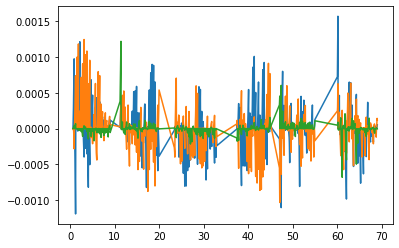

In [31]:
## Inspect the dead-reckoning position estimate
print(intervals)
ts_masked,state_masked=idx_filter(ts,state,intervals)
plt.plot(ts_masked,state_masked[:,0])
plt.plot(ts_masked,state_masked[:,1])
plt.plot(ts_masked,state_masked[:,2])

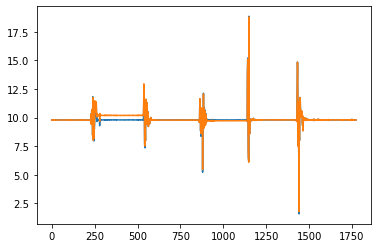

In [32]:
#Compare the uncalibrated vs calibrated acceleration magnitudes
plt.plot(np.sum(acc_calibrated**2,axis=1)**0.5  )
plt.plot(np.sum(acc**2,axis=1  )**0.5)